In [56]:
# Dependencies 
# !pip3 install torch torchvision torchaudio
# !pip3 install nuscenes-devkit

In [57]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from PIL import Image
import torch.nn.functional as F
from IPython.display import Image as IPImage

In [58]:
from nuscenes.can_bus.can_bus_api import NuScenesCanBus
from nuscenes.nuscenes import NuScenes
PATH = '/Users/jonathanmorris/Downloads/v1.0-mini'

nusc = NuScenes(version='v1.0-mini', dataroot=PATH, verbose=True)
nusc_can = NuScenesCanBus(dataroot=PATH)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.658 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [59]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [60]:
# Selecting first scene
my_scene = nusc.scene[3]
my_scene

{'token': 'bebf5f5b2a674631ab5c88fd1aa9e87a',
 'log_token': '6f7fe59adf984e55a82571ab4f17e4e2',
 'nbr_samples': 41,
 'first_sample_token': '5991fad3280c4f84b331536c32001a04',
 'last_sample_token': '35833ae5808e4ef186d1fdebac3d9cf6',
 'name': 'scene-0655',
 'description': 'Parking lot, parked cars, jaywalker, bendy bus, gardening vehicles'}

In [61]:
log = nusc.get('log', my_scene['log_token'])
log

{'token': '6f7fe59adf984e55a82571ab4f17e4e2',
 'logfile': 'n008-2018-08-27-11-48-51-0400',
 'vehicle': 'n008',
 'date_captured': '2018-08-27',
 'location': 'boston-seaport',
 'map_token': '36092f0b03a857c6a3403e25b4b7aab3'}

In [62]:
# Getting data from can expansion
my_scene_zoe_can = nusc_can.get_messages(my_scene['name'], 'zoesensors')
my_scene_zoe_can[0]

{'brake_sensor': 0.1841101199388504,
 'steering_sensor': 0.2177281528711319,
 'throttle_sensor': 0.12424559891223907,
 'utime': 1535385092151255}

In [63]:
my_scene_imu_can = nusc_can.get_messages(my_scene['name'], 'ms_imu')
my_scene_imu_can[0]

{'linear_accel': [-0.1565881371498108, -0.3427075743675232, 9.566261291503906],
 'q': [0.7119815349578857,
  -0.00927335862070322,
  0.011033848859369755,
  -0.7020502686500549],
 'rotation_rate': [0.0055993846617639065,
  0.001979708904400468,
  0.001327197765931487],
 'utime': 1535385092156118}

In [64]:
my_scene_vehicle_monitor_can = nusc_can.get_messages(my_scene['name'], 'vehicle_monitor')
my_scene_vehicle_monitor_can[0]

{'available_distance': 50,
 'battery_level': 80,
 'brake': 0,
 'brake_switch': 1,
 'gear_position': 7,
 'left_signal': 0,
 'rear_left_rpm': 237.60660000000001,
 'rear_right_rpm': 242.5272,
 'right_signal': 0,
 'steering': 0.3000000000001819,
 'steering_speed': 1.8118839761882555e-13,
 'throttle': 239,
 'utime': 1535385092194360,
 'vehicle_speed': 27.23,
 'yaw_rate': -0.0999999999999659}

In [65]:
# Get first sample
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
my_sample

{'token': '5991fad3280c4f84b331536c32001a04',
 'timestamp': 1535385092150099,
 'prev': '',
 'next': '2578329fc3ae484bb23ef766808f4be5',
 'scene_token': 'bebf5f5b2a674631ab5c88fd1aa9e87a',
 'data': {'RADAR_FRONT': '9c0e927f845e412c93cb2846bb72f27f',
  'RADAR_FRONT_LEFT': 'fbb8f507b73c435ab16bab9f509f2218',
  'RADAR_FRONT_RIGHT': '2484789d50b645bbabacc8e735d8af13',
  'RADAR_BACK_LEFT': '0fc32f1d2160443f9eedaa8edcfd05bf',
  'RADAR_BACK_RIGHT': 'da0903784e9646c39125737bea931db6',
  'LIDAR_TOP': '603a96c23db34acf8b5953d958df293d',
  'CAM_FRONT': 'be95ce80ec624f81ba6737eb67241215',
  'CAM_FRONT_RIGHT': 'de7f64fb4882443e99b21e51997756d7',
  'CAM_BACK_RIGHT': '0cdb6b298b814b38bf9d7544f7f502a5',
  'CAM_BACK_LEFT': '0d0a7c385ac84d64a4e8bd0545aff787',
  'CAM_BACK': 'f256db4ccc1d41d9920e168184d2411f',
  'CAM_FRONT_LEFT': '514d62f8cd534483a9d9509b26e87041'},
 'anns': ['8b979f63281c4955afe07d57a21aa0e1',
  'be3536192b93448394597729df1cf52f',
  'b6ded29415ae4ad2b76f0bf73fb674ce',
  '15bc2adc7b6b48bf8

In [66]:
print(nusc_can.can_blacklist)
print(nusc.scene[0]['name'])
print(int(nusc.scene[0]['name'].split("-")[1]))

[161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 175, 176, 309, 310, 311, 312, 313, 314]
scene-0061
61


In [67]:
def get_closest_can(time, can_objects):
    closest = {}
    prev_diff = 1000000 # 1 Second in microseconds
    for object in can_objects:
        diff = object["utime"] - time
        if diff > 0 and diff < prev_diff:
            closest = object
            prev_diff = diff
    # print("Time difference: ", prev_diff)
    return closest

def normalize(value, min, max):
    # Figure out how 'wide' each range is
    leftSpan = max - min

    # Convert the left range into a 0-1 range (float)
    return float(value - min) / float(leftSpan)

def num_to_range(num, inMin, inMax, outMin, outMax):
  return outMin + (float(num - inMin) / float(inMax - inMin) * (outMax - outMin))

def normalize_zoe_can(can_obj):
    new_obj = {}
    
    # These values are from here: https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/can_bus/README.md#zoe-sensors
    min_breaking = 0.166
    max_breaking = 0.631

    min_steering = 0.176
    max_steering = 0.252
    
    min_throttle = 0.105
    max_throttle = 0.411

    # convert values from 0-1
    new_obj["brake_sensor"] = num_to_range(can_obj["brake_sensor"], min_breaking, max_breaking, 0, 1)
    new_obj["steering_sensor"] = num_to_range(can_obj["steering_sensor"], min_steering, max_steering, -1, 1)
    new_obj["throttle_sensor"] = num_to_range(can_obj["throttle_sensor"], min_throttle, max_throttle, 0, 1)

    # reduce precision
    new_obj["brake_sensor"] = round(can_obj["brake_sensor"], 2)
    new_obj["steering_sensor"] = round(can_obj["steering_sensor"], 2)
    new_obj["throttle_sensor"] = round(can_obj["throttle_sensor"], 2)
    
    return new_obj

def normalize_vehicle_monitor_can(can_obj):
    new_obj = {}

    min_brake = 0
    max_break = 126

    min_steering = -780
    max_steering = 779.9

    min_throttle = 0
    max_throttle = 1000

    new_obj["brake"] = num_to_range(can_obj["brake"], min_brake, max_break, 0, 1)
    new_obj["steering"] = num_to_range(can_obj["steering"], min_steering, max_steering, -1, 1)
    new_obj["throttle"] = num_to_range(can_obj["throttle"], min_throttle, max_throttle, 0, 1)

    new_obj["brake"] = round(new_obj["brake"], 1)
    new_obj["steering"] = round(new_obj["steering"], 1)
    new_obj["throttle"] = round(new_obj["throttle"], 1)

    return new_obj

In [68]:
can_data = get_closest_can(my_sample['timestamp'], my_scene_zoe_can)
can_data


{'brake_sensor': 0.1841101199388504,
 'steering_sensor': 0.2177281528711319,
 'throttle_sensor': 0.12424559891223907,
 'utime': 1535385092151255}

In [69]:
normalize_zoe_can(can_data)

{'brake_sensor': 0.18, 'steering_sensor': 0.22, 'throttle_sensor': 0.12}

In [88]:
vehicle_monitor = get_closest_can(my_sample['timestamp'], my_scene_vehicle_monitor_can)
vehicle_monitor

{'available_distance': 50,
 'battery_level': 80,
 'brake': 0,
 'brake_switch': 1,
 'gear_position': 7,
 'left_signal': 0,
 'rear_left_rpm': 262.3764,
 'rear_right_rpm': 267.297,
 'right_signal': 0,
 'steering': 0.3000000000001819,
 'steering_speed': -5.999999999999819,
 'throttle': 128,
 'utime': 1535385097194420,
 'vehicle_speed': 29.94,
 'yaw_rate': 2.842170943040401e-14}

In [89]:
normalize_vehicle_monitor_can(vehicle_monitor)

{'brake': 0.0, 'steering': 0.0, 'throttle': 0.1}

In [70]:
imu_data = get_closest_can(my_sample['timestamp'], my_scene_imu_can)
imu_data

{'linear_accel': [-0.1565881371498108, -0.3427075743675232, 9.566261291503906],
 'q': [0.7119815349578857,
  -0.00927335862070322,
  0.011033848859369755,
  -0.7020502686500549],
 'rotation_rate': [0.0055993846617639065,
  0.001979708904400468,
  0.001327197765931487],
 'utime': 1535385092156118}

In [71]:
# Acceleration on x, y, z axis, m/s^2
acc = imu_data['linear_accel']
acc

[-0.1565881371498108, -0.3427075743675232, 9.566261291503906]

In [72]:
acc = torch.tensor([acc[0], acc[1], acc[2]])
acc

tensor([-0.1566, -0.3427,  9.5663])

In [73]:
# Check tensor size
acc.size()

torch.Size([3])

In [74]:
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
current_image_path = PATH+"/"+cam_front_data['filename']

In [75]:
img = Image.open(current_image_path)
convert_tensor = transforms.ToTensor()
tensor = convert_tensor(img)
tensor.size()

torch.Size([3, 900, 1600])

In [76]:
def get_next_data(scene, sample):
    next_token = sample["next"]
    next_sample = nusc.get("sample", next_token)
    can_data = nusc_can.get_messages(scene['name'], 'zoesensors')
    get_closest_can(next_sample["timestamp"], my_scene_zoe_can)
    return (next_sample, can_data)

get_next_data(my_scene,my_sample)

({'token': '2578329fc3ae484bb23ef766808f4be5',
  'timestamp': 1535385092700299,
  'prev': '5991fad3280c4f84b331536c32001a04',
  'next': '8057958576034e51bac9bdc5740128d5',
  'scene_token': 'bebf5f5b2a674631ab5c88fd1aa9e87a',
  'data': {'RADAR_FRONT': '9153685fd3f34928b62eaa72cbf1bf3d',
   'RADAR_FRONT_LEFT': '15d280f53c8e478c86b8213339301e46',
   'RADAR_FRONT_RIGHT': '756c81e602c14f8685402353eed94cbb',
   'RADAR_BACK_LEFT': '98ee591071164af693b79846ade99a4e',
   'RADAR_BACK_RIGHT': '727a8a998d1940fca91e57db169d0efe',
   'LIDAR_TOP': '00d437419bec4cb48b8feac9a77875c8',
   'CAM_FRONT': 'd35f5f1183da4cd9a744d9e265a6e40a',
   'CAM_FRONT_RIGHT': '3876d04219b347bb9dcdaf4568c685f0',
   'CAM_BACK_RIGHT': '63b083b5e5b54a26a567ba26f4e1b53b',
   'CAM_BACK': '4f0123a4df2042fdb25bda094c3e2670',
   'CAM_BACK_LEFT': 'bd98b08924ff45769999bda4e58a4ab6',
   'CAM_FRONT_LEFT': '26b1b47645954212a9435d6a5a87a4ae'},
  'anns': ['ac10d66872404234841b650db35cdfee',
   'd1f39f0cd8f34054831b8ed49c4f9b80',
   '87d

In [77]:
class LaneCNN(nn.Module):
    def __init__(self):
        super(LaneCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 3) # output three values -> [steering, throttle, breaking]

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = x.view(256 * 28 * 28)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

In [78]:
class MultiModalModel(nn.Module):
    def __init__(self):
        super(MultiModalModel, self).__init__()
        # Image processing branch - Convolutional layers
        self.image_branch = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),  # Adjusted input size
            nn.ReLU()
        )
        # Float processing branch - Fully connected layers
        self.float_branch = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU()
        )
        # Final output layer
        self.final_layer = nn.Linear(128 + 32, 3)

    def forward(self, image, floats):
        image_out = self.image_branch(image)
        float_out = self.float_branch(floats)
        float_out = float_out.unsqueeze(0).repeat(image_out.size(0), 1)

        # Concatenate the outputs of the two branches
        concat_out = torch.cat((image_out, float_out), dim=1)
        
        # Pass through final layer
        out = self.final_layer(concat_out)
        return out

In [79]:
learning_rate = 0.001
batch_size = 64
epochs = 10
model_path = os.path.join(os.getcwd(), "models")

!mkdir models && cd models && mkdir epochs

print(model_path)
transform = transforms.Compose(
        [transforms.Resize((224, 224), antialias=True), transforms.ToTensor()]
    )
model_file_name = "nuscenes_model_v1.1.pth"

mkdir: models: File exists
/Users/jonathanmorris/Developer/cruz-control/nuscenes/lane_following/models


In [80]:
def train():
    # path = sys.argv[1]
    print("Model Version V1.1")
    print("final model weights will be saved to: " + model_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "mps")

    scenes = nusc.scene

    train_size = int(0.8 * len(scenes))
    val_size = len(scenes) - train_size
    train, val = random_split(scenes, [train_size, val_size])

    net = LaneCNN().to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    print(f"Training on {device}")

    for epoch in range(epochs):
        net.train()
        for scene in train:
            
            scene_number = int(scene['name'].split("-")[1])

            if scene_number in nusc_can.can_blacklist:
                print("Skipping scene " + str(scene_number))
                continue
            
            first_sample_token = scene['first_sample_token']

            current_sample = nusc.get('sample', first_sample_token)

            scene_vehicle_monitor = nusc_can.get_messages(scene['name'], 'vehicle_monitor')

            while True:
                sensor = "CAM_FRONT"
                cam_front_data = nusc.get("sample_data", current_sample["data"][sensor])
                current_image_path = PATH + "/" + cam_front_data["filename"]
                img = Image.open(current_image_path)

                img_input = transform(img).to(device)
            
                current_vehicle_can = get_closest_can(current_sample["timestamp"], scene_vehicle_monitor)                    

                if current_vehicle_can == {}:
                    if current_sample['next'] == '':
                        break
                    else:
                        current_sample = nusc.get('sample', current_sample['next'])
                        continue

                normal_vm_can = normalize_vehicle_monitor_can(current_vehicle_can)

                steering_targets = normal_vm_can['steering']
                throttle_targets = normal_vm_can['throttle']
                breaking_targets = normal_vm_can['brake']

                label = torch.FloatTensor([steering_targets, throttle_targets, breaking_targets]).to(device)              

                optimizer.zero_grad()
                
                # Forward pass
                outputs = net(img_input)

                # Compute loss
                total_loss = criterion(outputs, label)

                # Backward pass
                total_loss.backward()

                # Update weights
                optimizer.step()

                if current_sample['next'] == '':
                    break
                else:
                    current_sample = nusc.get('sample', current_sample['next'])

        # Validation
        net.eval()
        with torch.no_grad():
            for scene in val:
                scene_number = int(scene['name'].split("-")[1])

                if scene_number in nusc_can.can_blacklist:
                    print("Skipping scene " + str(scene_number))
                    continue

                first_sample_token = scene['first_sample_token']

                current_sample = nusc.get('sample', first_sample_token)

                scene_vehicle_monitor = nusc_can.get_messages(scene['name'], 'vehicle_monitor')
                scene_imu_cans = nusc_can.get_messages(scene['name'], 'ms_imu')

                while True:
                    sensor = "CAM_FRONT"
                    cam_front_data = nusc.get("sample_data", current_sample["data"][sensor])
                    current_image_path = PATH + "/" + cam_front_data["filename"]
                    img = Image.open(current_image_path)

                    img_input = transform(img).to(device)

                    current_vehicle_can = get_closest_can(current_sample["timestamp"], scene_vehicle_monitor)

                    if current_vehicle_can == {}:
                        if current_sample['next'] == '':
                            break
                        else:
                            current_sample = nusc.get('sample', current_sample['next'])
                            continue
                    
                    normal_vm_can = normalize_vehicle_monitor_can(current_vehicle_can)

                    steering_targets = normal_vm_can['steering']
                    throttle_targets = normal_vm_can['throttle']
                    breaking_targets = normal_vm_can['brake']

                    label = torch.FloatTensor([steering_targets, throttle_targets, breaking_targets]).to(device)

                    outputs = net(img_input)

                    val_total_loss = criterion(outputs, label)

                    if current_sample['next'] == '':
                        break
                    else:
                        current_sample = nusc.get('sample', current_sample['next'])

        print(
            f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss.item():.4f}, Validation Loss: {val_total_loss.item():.4f}"
        )
        torch.save(
            net.state_dict(),
            os.path.join(model_path, "epochs", f"model_e{epoch+1}.pth"),
        )

    print("Finished training")
    torch.save(net.state_dict(), os.path.join(model_path, model_file_name))

In [81]:
train()

Model Version V1.1
final model weights will be saved to: /Users/jonathanmorris/Developer/cruz-control/nuscenes/lane_following/models
Training on mps
Epoch 1/10, Loss: 0.0201, Validation Loss: 0.0007
Epoch 2/10, Loss: 0.0211, Validation Loss: 0.0008
Epoch 3/10, Loss: 0.0181, Validation Loss: 0.0002
Epoch 4/10, Loss: 0.0192, Validation Loss: 0.0020
Epoch 5/10, Loss: 0.0205, Validation Loss: 0.0006
Epoch 6/10, Loss: 0.0164, Validation Loss: 0.0009
Epoch 7/10, Loss: 0.0176, Validation Loss: 0.0004
Epoch 8/10, Loss: 0.0185, Validation Loss: 0.0100
Epoch 9/10, Loss: 0.0161, Validation Loss: 0.0251
Epoch 10/10, Loss: 0.0161, Validation Loss: 0.0005
Finished training


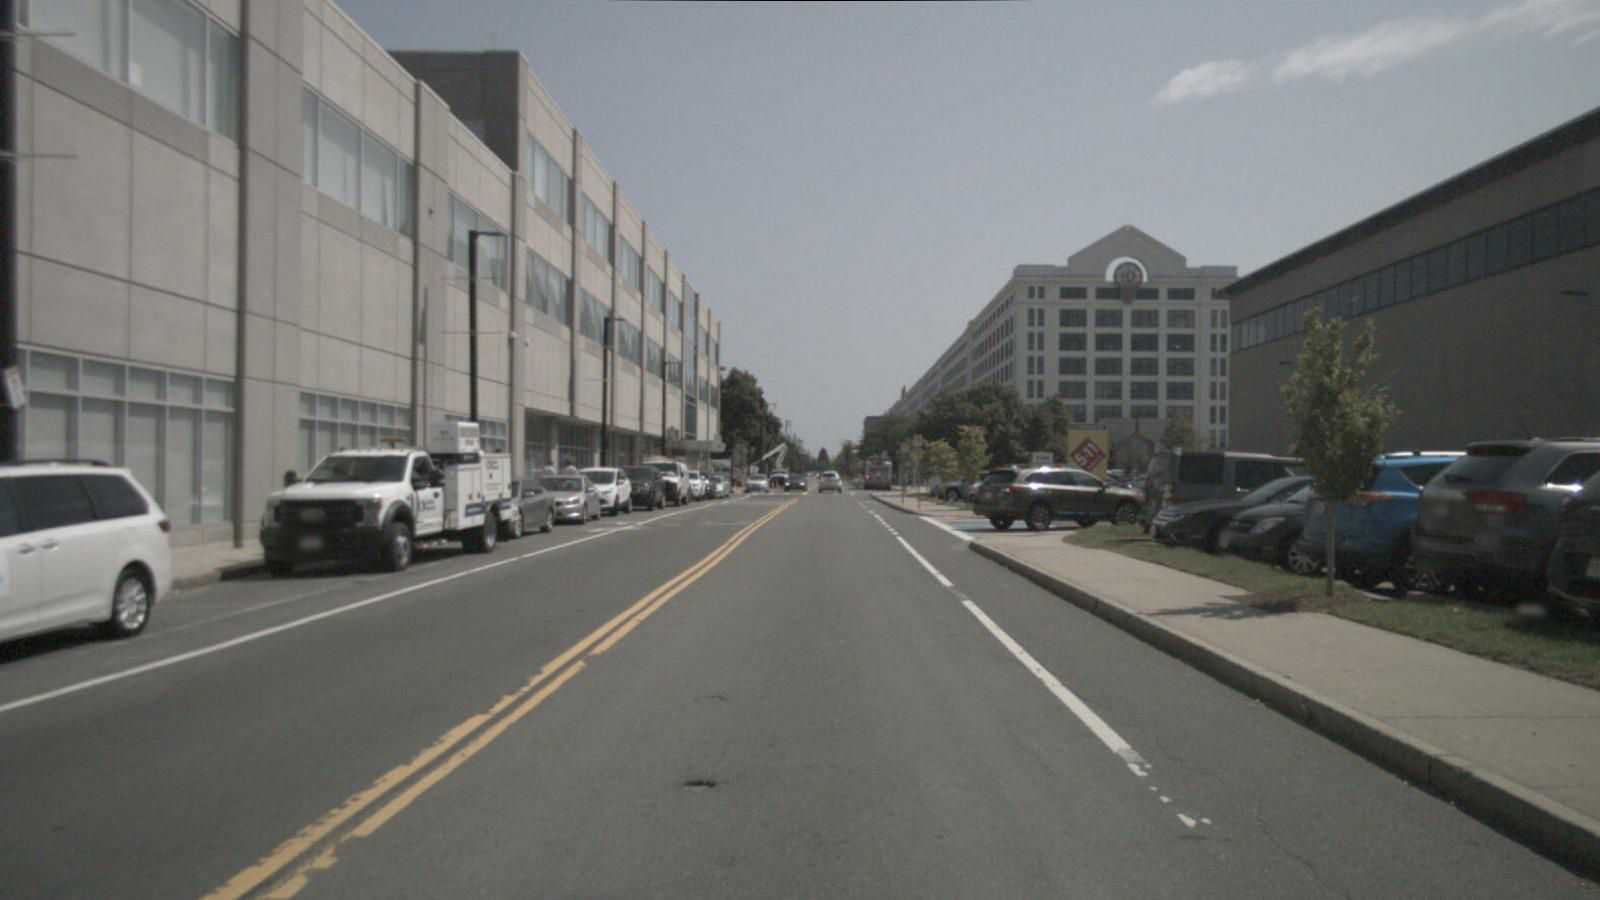

In [82]:
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
current_image_path = PATH+"/"+cam_front_data['filename']
img = Image.open(current_image_path)
image_tensor = transform(img)
IPImage(filename=current_image_path) 

In [90]:
os.path.join(model_path, model_file_name)

'/Users/jonathanmorris/Developer/cruz-control/nuscenes/lane_following/models/nuscenes_model_v1.1.pth'

In [83]:
model = LaneCNN()
model.load_state_dict(torch.load(model_path + "/" + model_file_name, map_location=torch.device('mps')))
model.eval()
model(image_tensor)

tensor([0.0095, 0.1061, 0.0089], grad_fn=<ViewBackward0>)

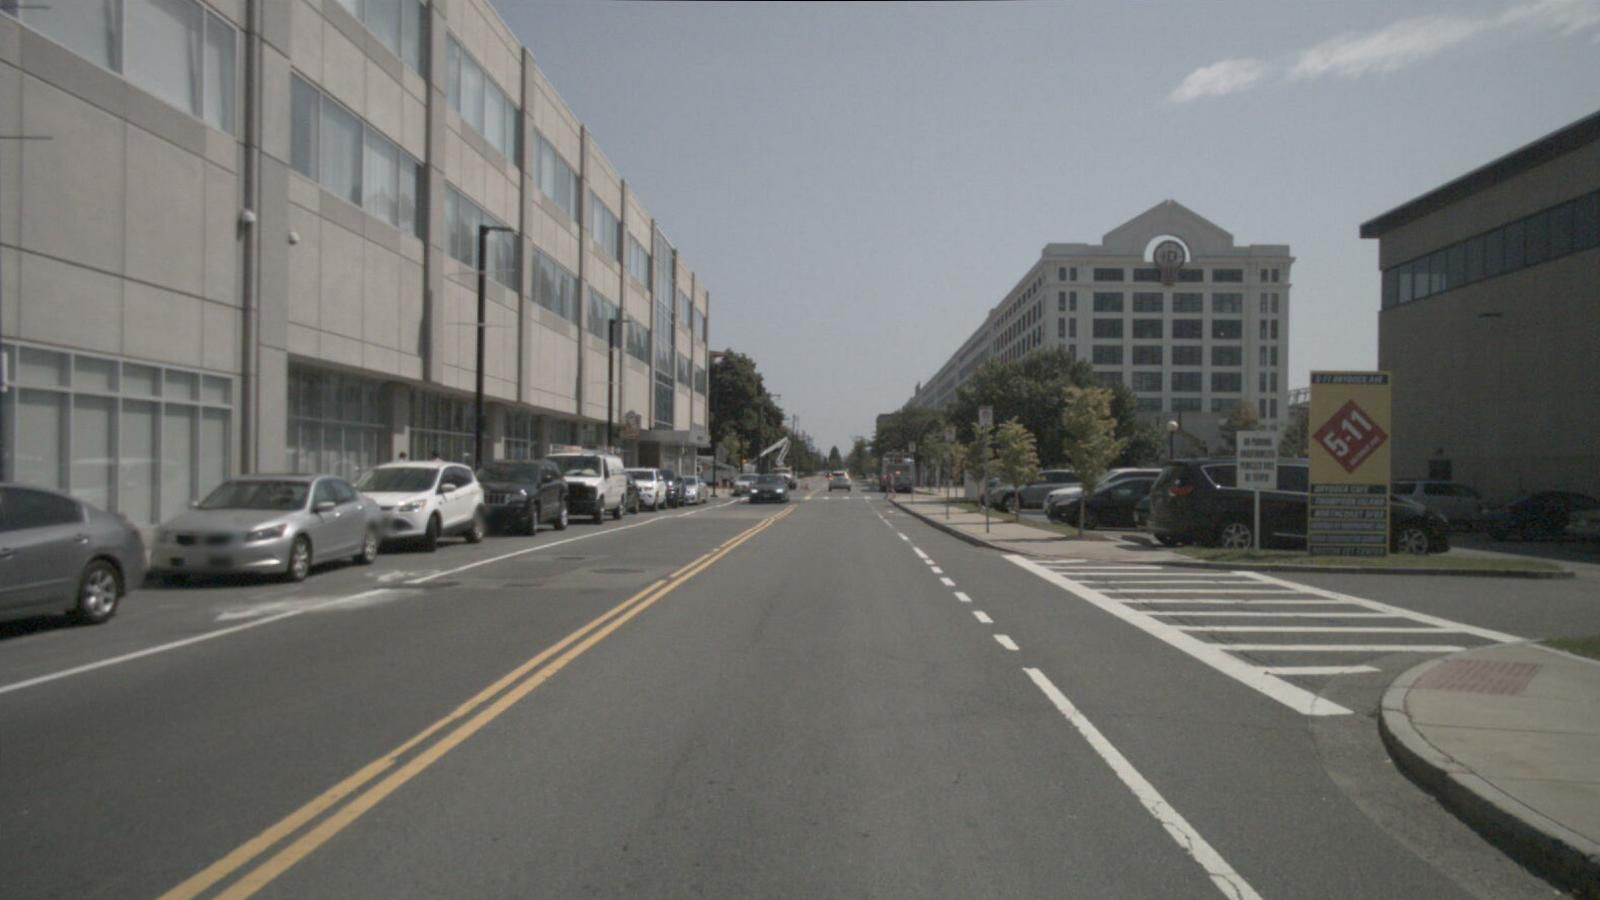

In [84]:
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
current_image_path = PATH+"/"+cam_front_data['filename']
img = Image.open(current_image_path)
image_tensor = transform(img)
IPImage(filename=current_image_path) 

In [85]:
model(image_tensor)

tensor([0.0087, 0.1056, 0.0091], grad_fn=<ViewBackward0>)

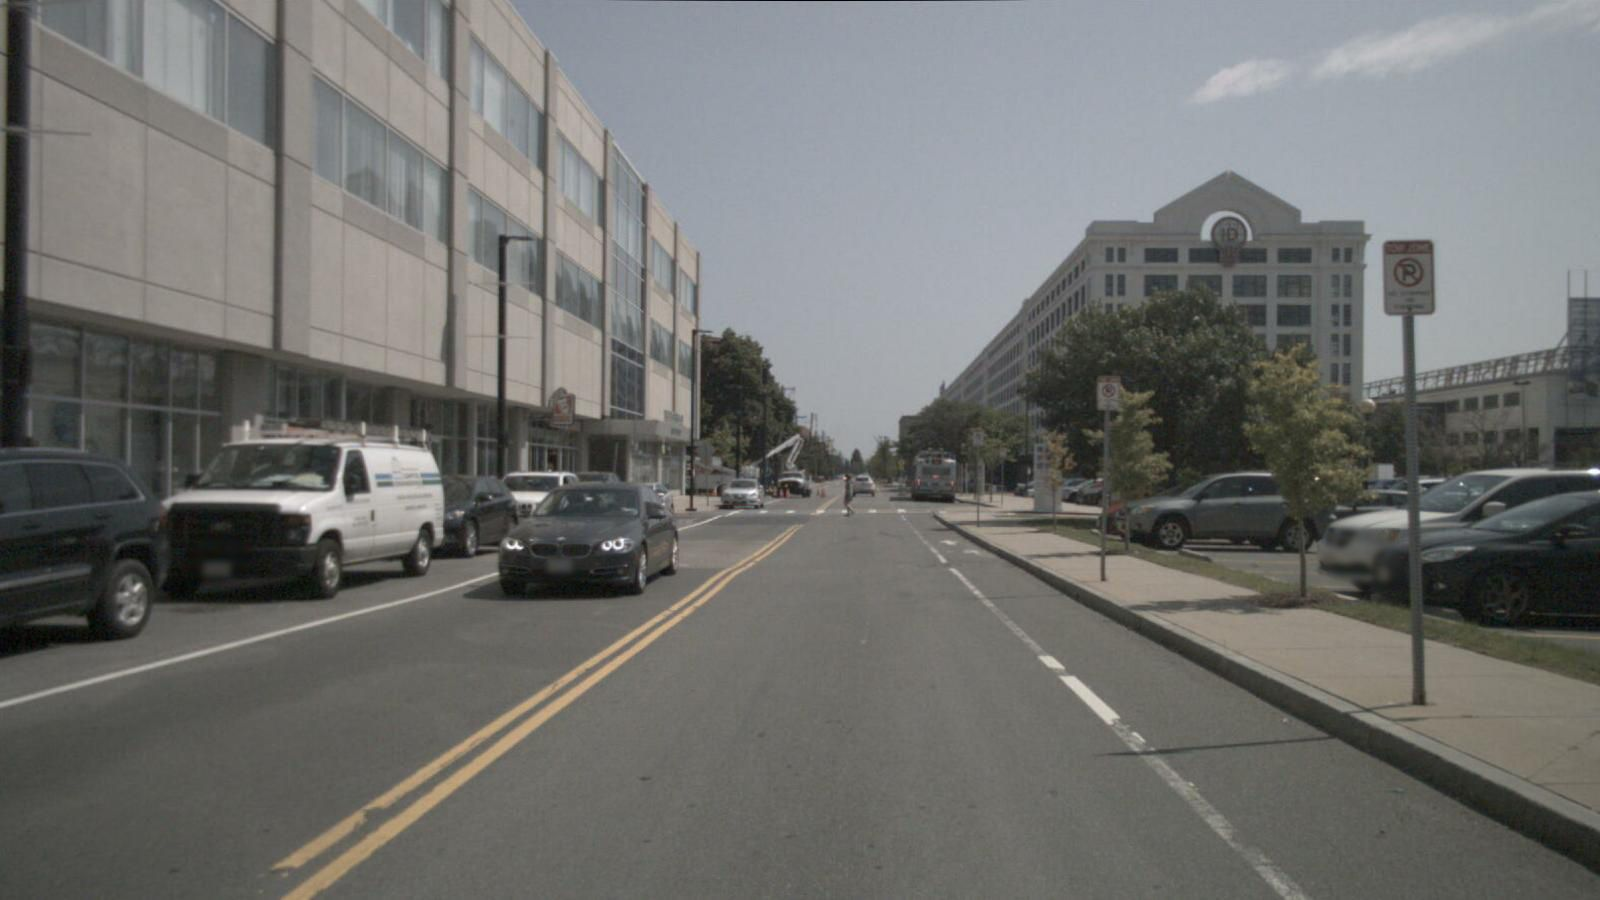

In [86]:
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
current_image_path = PATH+"/"+cam_front_data['filename']
img = Image.open(current_image_path)
image_tensor = transform(img)
IPImage(filename=current_image_path) 

In [87]:
model(image_tensor)

tensor([0.0087, 0.1056, 0.0092], grad_fn=<ViewBackward0>)